# The CNN Implementation
Author: Ali Stambayev

In [ ]:
# Compile Data
# 1 sample = 100x18 data, where 100 is the number of time points and 18 is the number of features
# 18 features: 8 EMG, 3 accelerometer, 3 gyroscope, 4 quaternions +  1 label that gets added from the filename = 19 columns of data
import os
import numpy as np
import pandas as pd
import glob

PATH = '../data/'

# Mapping of labels to integers and vice versa
CLASSES = {'idle':0, 'kick':1, 'pass':2, 'walk':3}
REVERSE_CLASSES = {0:'idle', 1:'kick', 2:'pass', 3:'walk'}  

def get_data(filepath):
    """
    Get data from the given path, and return a numpy array of shape (100, 19)
    :param path: path to the data file
    :return: numpy array of shape (100, 19)
    """
    # Read the data file
    df = pd.read_csv(filepath, header=None)
    
    # Convert to numpy array
    data = df.to_numpy()

    # Get the label from the filename
    label = filepath.split('_')[1]

    # Add the label to the data as the last column
    data = np.append(data, np.full((data.shape[0], 1), CLASSES.get(label)), axis=1)

    return data

def compile_data(participant):
    """
    Compile data from all files in the given path
    :return: numpy array of shape (n_samples, 100, 19)
    """
    # Get all files in the path
    files = glob.glob(os.path.join(PATH, participant, '*.csv'))
    # Initialize an empty numpy array
    data_list = []

    # Loop through all files and get the data
    for filepath in files:
        data = get_data(filepath)
        data_list.append(data)

    # Convert the list to a numpy array
    data_array = np.array(data_list)

    return data_array

def preprocess_data(data_array):
    """
    Preprocess the data by normalizing it
    :param data_array: numpy array of shape (n_samples, 100, 19)
    :return: normalized numpy array of shape (n_samples, 100, 19)
    """
    # Normalize the data
    data_array = (data_array - np.mean(data_array, axis=0)) / np.std(data_array, axis=0)

    return data_array

# Data Preparation

In [ ]:
from tensorflow.keras.utils import to_categorical

# Load the data
participants = ['Ali', 'Tyler', 'Issac']
data = np.empty((0, 101, 19))
for name in participants: 
    participant_data = compile_data(name)
    print(f"Participant {name} data shape: {participant_data[0].shape}")
    data = np.append(data, participant_data, axis=0)

# Shuffle and split the data into training and testing sets
num_samples = data.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]
train_data = data[train_indices]
test_data = data[test_indices]

# Separate features and labels
X_train = train_data[:, 1:, :-1].astype(np.float32)
X_test = test_data[:, 1:, :-1].astype(np.float32)
X_train = np.expand_dims(preprocess_data(X_train), axis=-1) 
X_test = np.expand_dims(preprocess_data(X_test), axis=-1)


# Grab the last column as the label
y_train = train_data[:, 0, -1].reshape(-1, 1)
y_test = test_data[:, 0, -1].reshape(-1, 1)
# One-hot encode the labels 
y_train = to_categorical(y_train.squeeze(), num_classes=4)
y_test = to_categorical(y_test.squeeze(), num_classes=4)


# Print the shapes of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Participant Ali data shape: (101, 19)
Participant Tyler data shape: (101, 19)
Participant Issac data shape: (101, 19)
X_train shape: (96, 100, 18, 1), y_train shape: (96, 4), X_test shape: (24, 100, 18, 1), y_test shape: (24, 4)


# Model Training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define CNN model
def create_cnn(num_classes=4):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
model = create_cnn()
# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_split=0.2)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4515 - loss: 1.3380 - val_accuracy: 0.2000 - val_loss: 1.3920
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4732 - loss: 1.2627 - val_accuracy: 0.5500 - val_loss: 1.2897
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5228 - loss: 1.2034 - val_accuracy: 0.6500 - val_loss: 1.2052
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6672 - loss: 1.1694 - val_accuracy: 0.6500 - val_loss: 1.1268
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4043 - loss: 1.1242 - val_accuracy: 0.6000 - val_loss: 1.0489
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7475 - loss: 0.8864 - val_accuracy: 0.7000 - val_loss: 0.9270
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7137 - loss: 0.7794 - val_accuracy: 0.6500 - val_loss: 0.8596
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6216 - loss: 0.8754 - val_accuracy: 0.6500 - v

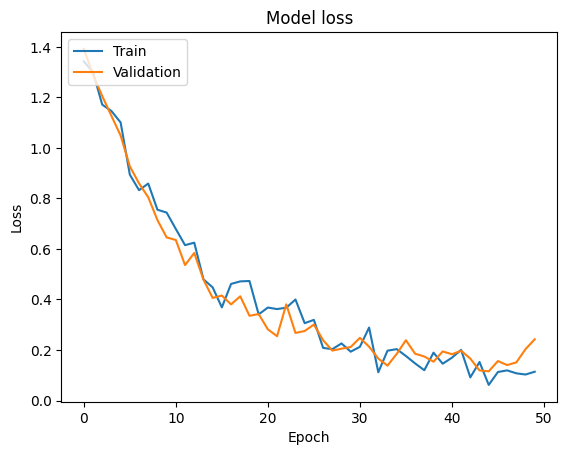

In [4]:
# Visualize training vs validation loss
plt.figure()
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


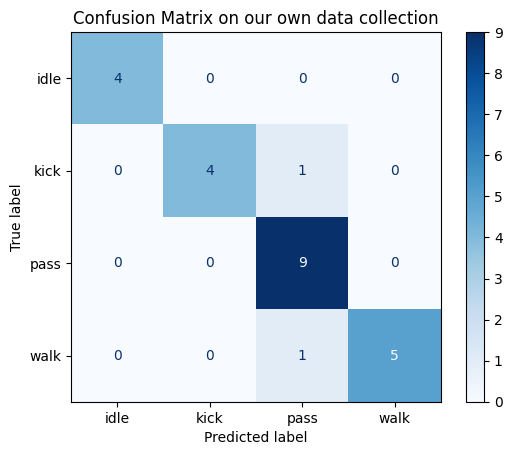

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00         4
        kick       0.80      1.00      0.89         4
        pass       1.00      0.82      0.90        11
        walk       0.83      1.00      0.91         5

    accuracy                           0.92        24
   macro avg       0.91      0.95      0.92        24
weighted avg       0.93      0.92      0.92        24



In [5]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate the model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
ConfusionMatrixDisplay.from_predictions(predicted_classes, true_classes, display_labels=CLASSES.keys(), cmap=plt.cm.Blues)
plt.title('Confusion Matrix on our own data collection')
plt.show()
print(classification_report(true_classes, predicted_classes, target_names=CLASSES.keys()))

# Validating on unseen data

X_unseen shape: (40, 100, 18, 1), y_unseen shape: (40, 4)
Participant Geoffrey data shape: (100, 18, 1)
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


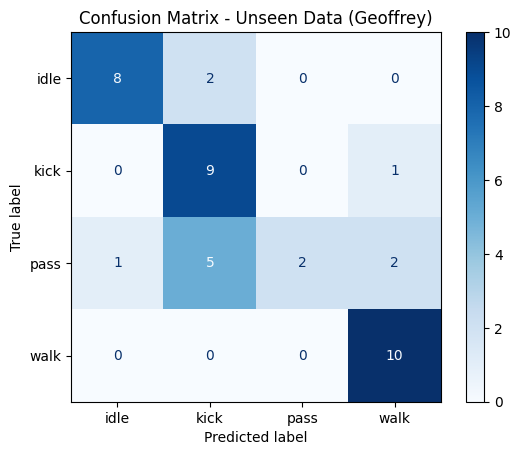

              precision    recall  f1-score   support

        idle       0.89      0.80      0.84        10
        kick       0.56      0.90      0.69        10
        pass       1.00      0.20      0.33        10
        walk       0.77      1.00      0.87        10

    accuracy                           0.72        40
   macro avg       0.81      0.73      0.68        40
weighted avg       0.81      0.72      0.68        40



In [6]:
data = np.empty((0, 101, 19))
participant = 'Geoffrey'
unseen_data = compile_data(participant)
data = np.append(data, unseen_data, axis=0)

# Shuffle the data
num_samples = data.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)
shuffled_data = data[indices]

# Separate features and labels
X_unseen = shuffled_data[:, 1:, :-1].astype(np.float32)
X_unseen = np.expand_dims(preprocess_data(X_unseen), axis=-1)
y_unseen = shuffled_data[:, 0, -1].reshape(-1, 1)
y_unseen = to_categorical(y_unseen.squeeze(), num_classes=4)

print(f"X_unseen shape: {X_unseen.shape}, y_unseen shape: {y_unseen.shape}")
print(f"Participant {participant} data shape: {X_unseen[0].shape}")

# Evaluate the model on unseen data
predictions_unseen = model.predict(X_unseen, batch_size=1)
predicted_classes_unseen = np.argmax(predictions_unseen, axis=1)
true_classes_unseen = np.argmax(y_unseen, axis=1)
ConfusionMatrixDisplay.from_predictions(true_classes_unseen, predicted_classes_unseen, display_labels=CLASSES.keys(), cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Unseen Data ({participant})')
plt.show()
print(classification_report(true_classes_unseen, predicted_classes_unseen, target_names=CLASSES.keys()))

In [7]:
# Predict 1 value to emulate Real-time
sample = X_unseen[0]
print(f"Sample shape: {sample.shape}")

# Reshape the sample to match the input shape of the model
sample = sample.reshape(1, 100, 18, 1)
print(f"Sample reshaped: {sample.shape}")

prediction = model.predict(sample, batch_size=1)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {predicted_class}, Label: {REVERSE_CLASSES[predicted_class]}")

Sample shape: (100, 18, 1)
Sample reshaped: (1, 100, 18, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: 3, Label: walk


In [ ]:
# Export Tensofrlow style model
model.save('SavedModels/2sTimeWindow_CNN_model.keras')

model.summary()


rewriter <function rewrite_constant_fold at 0x000001E3A7FB6700>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (4, 100, 18, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (4, 50, 9, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (4, 50, 9, 64)         │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (4, 25, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (4, 25, 4, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (4, 12, 2, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (4, 3072)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 128)               │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (4, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (4, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (4, 4)                 │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,483,598 (5.66 MB)

 Trainable params: 494,532 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 989,066 (3.77 MB)

# Time-series implementation
- Split the data into timeseries and pick windows of certain sizes to complete classifications. 

X_train_window shape: (96, 10, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 10, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1559 - loss: 1.4246 - val_accuracy: 0.4000 - val_loss: 1.3763
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3018 - loss: 1.3979 - val_accuracy: 0.4500 - val_loss: 1.3508
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3504 - loss: 1.3439 - val_accuracy: 0.6000 - val_loss: 1.3257
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3785 - loss: 1.3334 - val_accuracy: 0.5500 - val_loss: 1.3048
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4245 - loss: 1.2565 - val_accuracy: 0.5500 - val_loss: 1.2732
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5702 - loss: 1.2216 - val_accuracy: 0.5500 - val_loss: 1.2390
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4724 - loss: 1.2314 - val_accuracy: 0.5500 - val_loss: 1

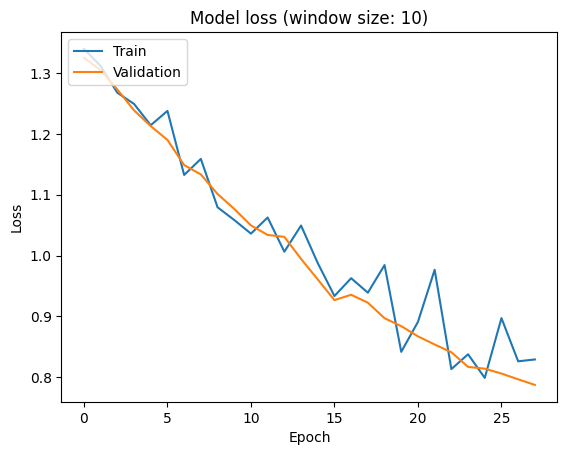

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Window size: 10


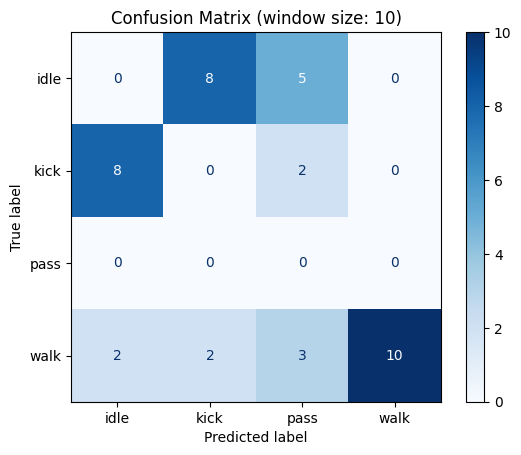

X_train_window shape: (96, 20, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 20, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2808 - loss: 1.4092 - val_accuracy: 0.2500 - val_loss: 1.3407
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3359 - loss: 1.3344 - val_accuracy: 0.1500 - val_loss: 1.3229
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2828 - loss: 1.3484 - val_accuracy: 0.2500 - val_loss: 1.3022
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4072 - loss: 1.2872 - val_accuracy: 0.3500 - val_loss: 1.2781
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3031 - loss: 1.3139 - val_accuracy: 0.3500 - val_loss: 1.2416
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5264 - loss: 1.1851 - val_accuracy: 0.3500 - val_loss: 1.2138
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5530 - loss: 1.1980 - val_accuracy: 0.3500 - val_loss

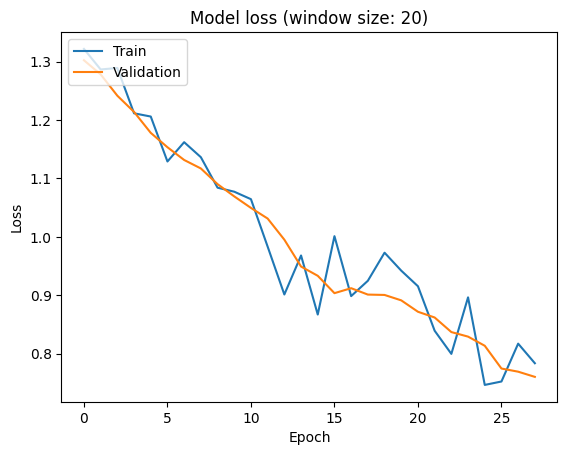

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Window size: 20


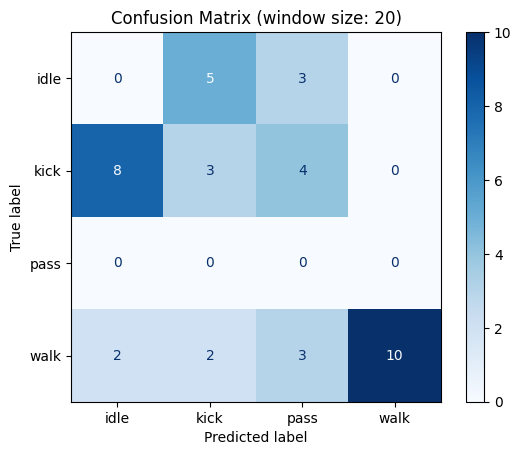

X_train_window shape: (96, 30, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 30, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3339 - loss: 1.3304 - val_accuracy: 0.6000 - val_loss: 1.3250
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3222 - loss: 1.3577 - val_accuracy: 0.6000 - val_loss: 1.3003
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4101 - loss: 1.2486 - val_accuracy: 0.6000 - val_loss: 1.2796
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3601 - loss: 1.2255 - val_accuracy: 0.4000 - val_loss: 1.2633
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5296 - loss: 1.1262 - val_accuracy: 0.3500 - val_loss: 1.2336
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4276 - loss: 1.2059 - val_accuracy: 0.3500 - val_loss: 1.2005
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6529 - loss: 1.0878 - val_accuracy: 0.3500 - val_loss: 1

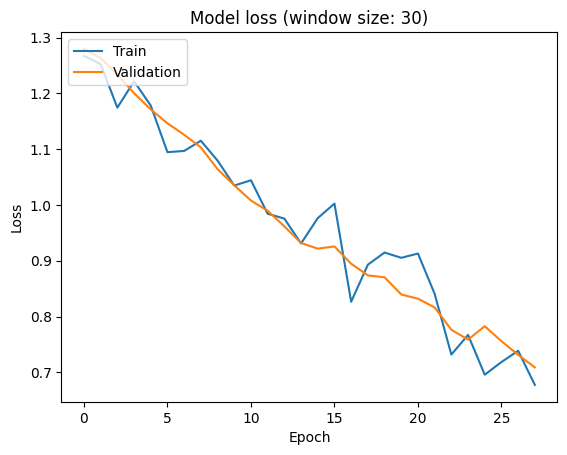

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Window size: 30


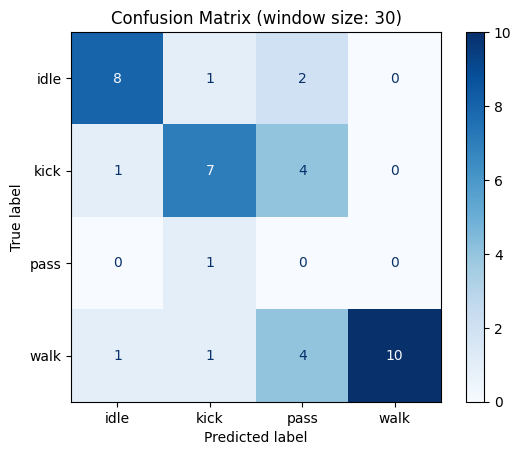

X_train_window shape: (96, 40, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 40, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1965 - loss: 1.4434 - val_accuracy: 0.6000 - val_loss: 1.3321
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3689 - loss: 1.3215 - val_accuracy: 0.6000 - val_loss: 1.3016
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4281 - loss: 1.2718 - val_accuracy: 0.4500 - val_loss: 1.2714
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4977 - loss: 1.2387 - val_accuracy: 0.5500 - val_loss: 1.2096
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4021 - loss: 1.1643 - val_accuracy: 0.4500 - val_loss: 1.1419
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5299 - loss: 1.1022 - val_accuracy: 0.6000 - val_loss: 1.0771
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5515 - loss: 1.0103 - val_accuracy: 0.6500 - val_loss

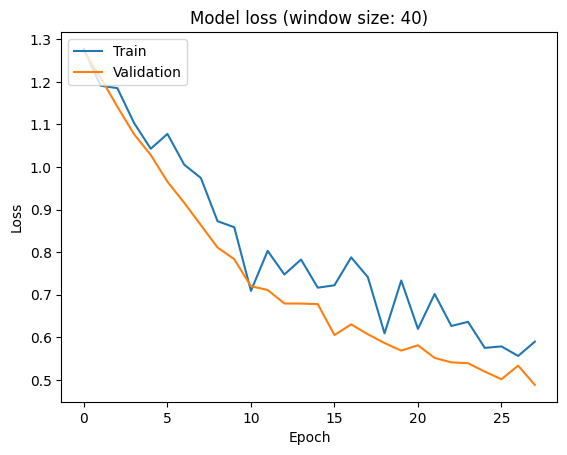

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Window size: 40


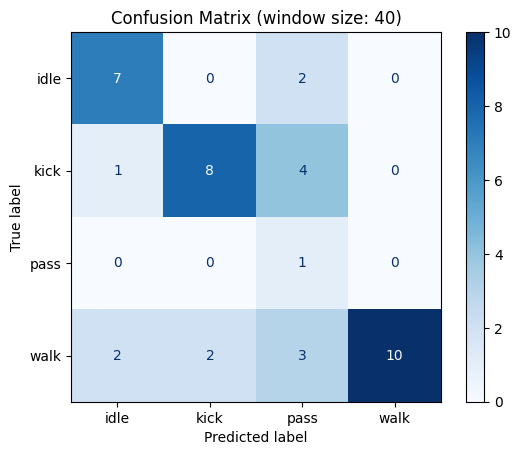

X_train_window shape: (96, 50, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 50, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2202 - loss: 1.4087 - val_accuracy: 0.2000 - val_loss: 1.3567
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2955 - loss: 1.3463 - val_accuracy: 0.2500 - val_loss: 1.3187
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4496 - loss: 1.2677 - val_accuracy: 0.3000 - val_loss: 1.2843
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5166 - loss: 1.1942 - val_accuracy: 0.4000 - val_loss: 1.2394
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3766 - loss: 1.2815 - val_accuracy: 0.5500 - val_loss: 1.1837
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5342 - loss: 1.1896 - val_accuracy: 0.6000 - val_loss: 1.1439
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5654 - loss: 1.1386 - val_accuracy: 0.7000 - val_l

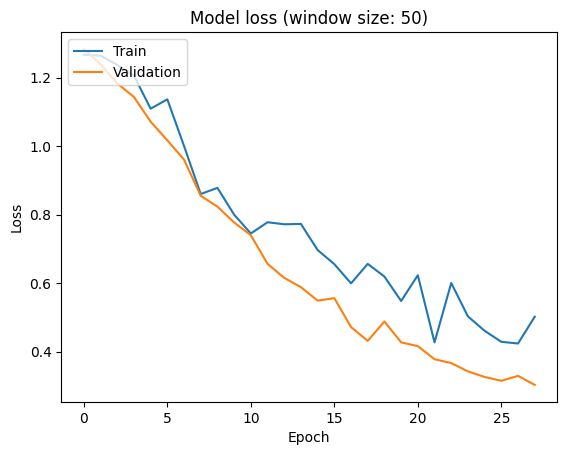

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Window size: 50


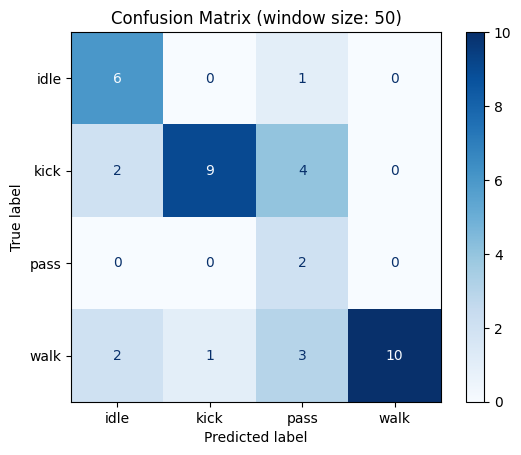

X_train_window shape: (96, 75, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 75, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2865 - loss: 1.3539 - val_accuracy: 0.3500 - val_loss: 1.3304
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4844 - loss: 1.2919 - val_accuracy: 0.3500 - val_loss: 1.2904
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4834 - loss: 1.2403 - val_accuracy: 0.6000 - val_loss: 1.2161
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3753 - loss: 1.2773 - val_accuracy: 0.5000 - val_loss: 1.1642
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5802 - loss: 1.1096 - val_accuracy: 0.6000 - val_loss: 1.0697
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5417 - loss: 1.1023 - val_accuracy: 0.7500 - val_loss: 0.9904
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6332 - loss: 1.0411 - val_accuracy: 0.8000 - val_l

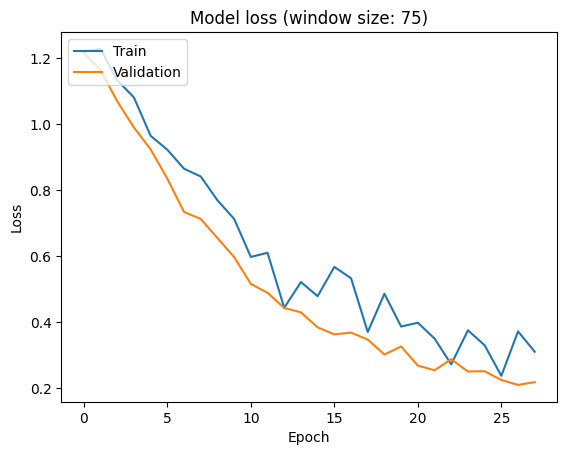

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Window size: 75


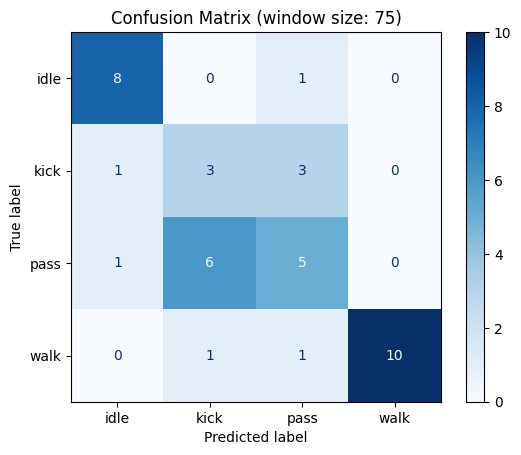

X_train_window shape: (96, 100, 18, 1), y_train shape: (96, 4), X_test_window shape: (40, 100, 18, 1), y_test shape: (40, 4)
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2852 - loss: 1.3726 - val_accuracy: 0.3000 - val_loss: 1.3082
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3700 - loss: 1.2632 - val_accuracy: 0.6000 - val_loss: 1.2451
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5012 - loss: 1.1848 - val_accuracy: 0.5000 - val_loss: 1.1997
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5699 - loss: 1.1137 - val_accuracy: 0.5500 - val_loss: 1.1095
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5686 - loss: 1.0009 - val_accuracy: 0.6500 - val_loss: 1.0204
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5543 - loss: 1.0786 - val_accuracy: 0.8500 - val_loss: 0.9581
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7575 - loss: 0.9177 - val_accuracy: 0.8000 - val

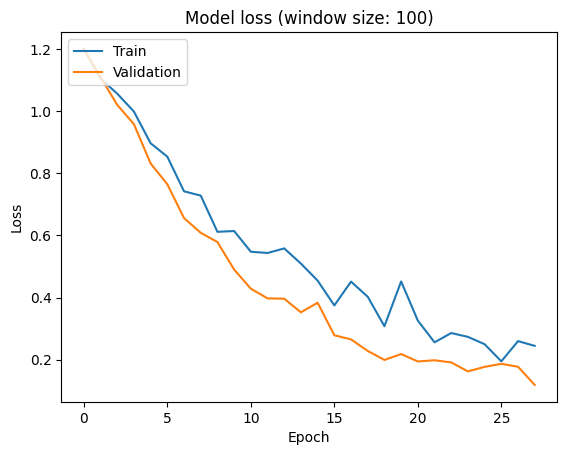

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Window size: 100


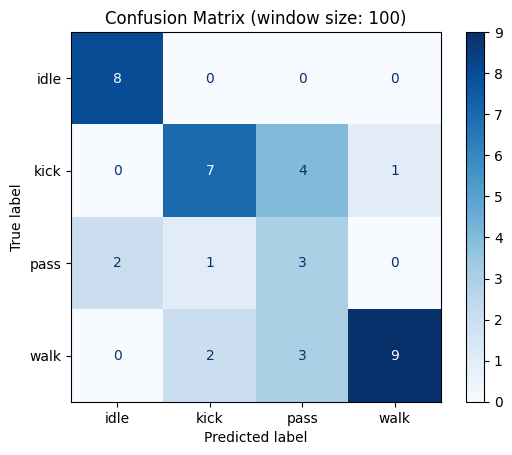

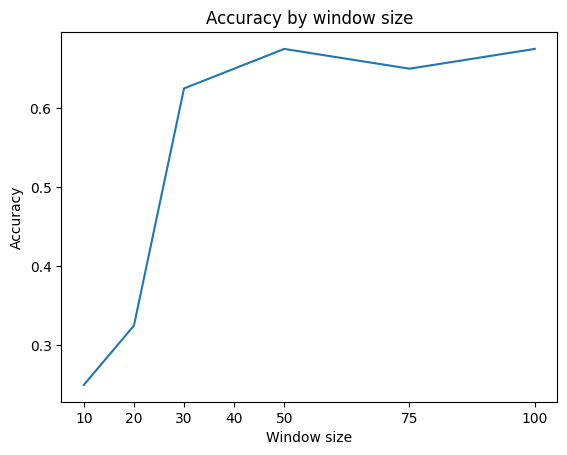

In [49]:
def select_time_window(X, window_size):
    # Select only the window_size amount of points from the start of each sample
    return X[:, :window_size, :]
    
# 50Hz sampling rate, 100 samples = 2 seconds
# 25 samples = 0.5 seconds
window_sizes = [10, 20, 30, 40, 50, 75, 100]
accuracys = []
for window_size in window_sizes:
    X_train_window = select_time_window(X_train, window_size)
    X_test_window = select_time_window(X_unseen, window_size)
    y_test = y_unseen
    
    # Create the model
    model = create_cnn(num_classes=4)

    # Print the shapes of the data
    print(f"X_train_window shape: {X_train_window.shape}, y_train shape: {y_train.shape}, X_test_window shape: {X_test_window.shape}, y_test shape: {y_test.shape}")
    # Train the model
    history = model.fit(X_train_window, y_train, epochs=30, batch_size=4, validation_split=0.2)

    # Visualize training vs validation loss
    plt.figure()
    plt.plot(history.history['loss'][2:])
    plt.plot(history.history['val_loss'][2:])
    plt.title(f'Model loss (window size: {window_size})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Evaluate the model
    predictions = model.predict(X_test_window)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Track Accuracy
    accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
    accuracys.append(accuracy)
    
    print(f"Window size: {window_size}")
    ConfusionMatrixDisplay.from_predictions(predicted_classes, true_classes, display_labels=CLASSES.keys(), cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (window size: {window_size})')
    plt.show()

# Plot the accuracies by window size
plt.figure()
plt.plot(window_sizes, accuracys)
plt.title('Accuracy by window size')
plt.ylabel('Accuracy')
plt.xlabel('Window size')
plt.xticks(window_sizes)
plt.show()